In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from IPython.display import display
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

### Import datasets 

In [2]:
df_products = pd.read_csv('../../eda/datasets/project_1_dataset/products.csv')
df_aisles = pd.read_csv('../../eda/datasets/project_1_dataset/aisles.csv')
df_departments = pd.read_csv('../../eda/datasets/project_1_dataset/departments.csv')
df_ordered_products = pd.read_csv('../../eda/datasets/project_1_dataset/order_products.csv')
df_orders = pd.read_csv('../../eda/datasets/project_1_dataset/orders.csv')

### Merge required datasets

In [3]:
df = pd.merge(df_orders, df_ordered_products, on='order_id', how='inner')
df.drop(columns=['eval_set', 'order_number', 'add_to_cart_order','reordered'], inplace=True, axis=1)
df = pd.merge(df, df_products, on='product_id', how='inner')
print('done')

done


In [4]:
df.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,aisle_id,department_id
0,2539329,1,2,8,NaN,196,Soda,77,7
1,2539329,1,2,8,NaN,14084,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,2,8,NaN,12427,Original Beef Jerky,23,19
3,2539329,1,2,8,NaN,26088,Aged White Cheddar Popcorn,23,19
4,2539329,1,2,8,NaN,26405,XL Pick-A-Size Paper Towel Rolls,54,17


### NaN value handling

In [5]:
df.fillna(-1, inplace=True)
df['days_since_prior_order'] = df['days_since_prior_order'] + 1

In [6]:
df.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,aisle_id,department_id
0,2539329,1,2,8,0.0,196,Soda,77,7
1,2539329,1,2,8,0.0,14084,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,2,8,0.0,12427,Original Beef Jerky,23,19
3,2539329,1,2,8,0.0,26088,Aged White Cheddar Popcorn,23,19
4,2539329,1,2,8,0.0,26405,XL Pick-A-Size Paper Towel Rolls,54,17


### Stratify data

In [7]:
def stratified_sample(df, stratify_col, frac):
    
    stratified_df = df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))

    stratified_df = stratified_df.reset_index(drop=True)
    
    return stratified_df

In [8]:
df = stratified_sample(df, 'user_id', frac=0.3)
# df = pd.read_csv('filename.csv')

In [9]:
df.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,aisle_id,department_id
0,2539329,1,2,8,0.0,196,Soda,77,7
1,2398795,1,3,7,16.0,196,Soda,77,7
2,550135,1,1,9,21.0,10258,Pistachios,117,19
3,473747,1,3,12,22.0,10258,Pistachios,117,19
4,2295261,1,1,16,1.0,46149,Zero Calorie Cola,77,7


In [10]:
df.shape

(9730409, 9)

In [11]:
# df.drop(columns=['user_order_count','total_items_ordered','product_popularity','avg_order_hour','order_frequency',
#                  'department_affinity','preferred_order_dow','avg_reorder_rate','user_product_reorder_rate'],
#        inplace=True)

### Creating unique user profiles

In [12]:
def aggregate_user_data(df):
    """
    Aggregates the data to create a single row per user with summarized features for clustering.

    Parameters:
    - df (pd.DataFrame): The input dataframe containing user purchase data.

    Returns:
    - pd.DataFrame: Aggregated user data with one row per user.
    """
    
    # 1. Total Orders per User (count of unique orders)
    total_orders = df.groupby('user_id')['order_id'].nunique().reset_index()
    total_orders.rename(columns={'order_id': 'total_orders'}, inplace=True)

    # 2. Days Since Last Order (recency of last order)
    days_since_last_order = df.groupby('user_id')['days_since_prior_order'].last().reset_index()
    days_since_last_order.rename(columns={'days_since_prior_order': 'days_since_last_order'}, inplace=True)

    # 3. Average Days Between Orders (order frequency)
    avg_order_frequency = df.groupby('user_id')['days_since_prior_order'].mean().reset_index()
    avg_order_frequency.rename(columns={'days_since_prior_order': 'avg_days_between_orders'}, inplace=True)

    # 4. Unique Products Purchased (number of different products bought)
    unique_products = df.groupby('user_id')['product_id'].nunique().reset_index()
    unique_products.rename(columns={'product_id': 'unique_products'}, inplace=True)

    # 5. Most Frequent Aisle (mode of aisle_id)
    most_frequent_aisle = df.groupby('user_id')['aisle_id'].agg(lambda x: x.mode()[0]).reset_index()
    most_frequent_aisle.rename(columns={'aisle_id': 'most_frequent_aisle'}, inplace=True)

    # 6. Most Frequent Department (mode of department_id)
    most_frequent_dept = df.groupby('user_id')['department_id'].agg(lambda x: x.mode()[0]).reset_index()
    most_frequent_dept.rename(columns={'department_id': 'most_frequent_dept'}, inplace=True)

    # 7. Basket Size (average number of items per order)
    basket_size = df.groupby('user_id')['order_id'].count().reset_index()
    basket_size.rename(columns={'order_id': 'basket_size'}, inplace=True)

    # 8. Repeat Purchases (percentage of reordered items)
    repeat_purchases = df.groupby('user_id')['product_id'].apply(lambda x: (x.duplicated().sum() / len(x)) * 100).reset_index()
    repeat_purchases.rename(columns={'product_id': 'repeat_purchase_percentage'}, inplace=True)

    # 9. Average Hour of Day for Purchases (when users tend to purchase)
    avg_purchase_time = df.groupby('user_id')['order_hour_of_day'].mean().reset_index()
    avg_purchase_time.rename(columns={'order_hour_of_day': 'avg_purchase_hour'}, inplace=True)

    # 10. Weekend Shopper (percentage of purchases made on weekends)
    df['is_weekend'] = df['order_dow'].apply(lambda x: 1 if x in [0, 6] else 0)
    weekend_shopper = df.groupby('user_id')['is_weekend'].mean().reset_index()
    weekend_shopper.rename(columns={'is_weekend': 'weekend_shopper_percentage'}, inplace=True)

    # 11. Last Purchased Aisle and Department (based on last order)
    last_purchased_aisle = df.groupby('user_id')['aisle_id'].last().reset_index()
    last_purchased_aisle.rename(columns={'aisle_id': 'last_purchased_aisle'}, inplace=True)

    last_purchased_dept = df.groupby('user_id')['department_id'].last().reset_index()
    last_purchased_dept.rename(columns={'department_id': 'last_purchased_dept'}, inplace=True)

    # Merging all features into a single dataframe (join on user_id)
    df_aggregated = total_orders.merge(days_since_last_order, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(avg_order_frequency, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(unique_products, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(most_frequent_aisle, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(most_frequent_dept, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(basket_size, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(repeat_purchases, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(avg_purchase_time, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(weekend_shopper, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(last_purchased_aisle, on='user_id', how='left')
    df_aggregated = df_aggregated.merge(last_purchased_dept, on='user_id', how='left')

    return df_aggregated

In [13]:
user_profiles = aggregate_user_data(df)

In [14]:
user_profiles.head()

,user_id,total_orders,days_since_last_order,avg_days_between_orders,unique_products,most_frequent_aisle,most_frequent_dept,basket_size,repeat_purchase_percentage,avg_purchase_hour,weekend_shopper_percentage,last_purchased_aisle,last_purchased_dept
0,1,9,0.0,15.444444,11,23,19,18,38.888889,10.000000,0.000000,54,17
1,2,14,14.0,15.775862,45,24,19,58,22.413793,10.155172,0.000000,72,13
2,3,11,8.0,11.192308,17,24,4,26,34.615385,16.576923,0.461538,91,16
3,4,3,0.0,8.400000,5,74,3,5,0.000000,11.800000,0.600000,74,17
4,5,4,0.0,11.545455,10,120,4,11,9.090909,15.818182,0.272727,84,16


### Feature Scaling

In [15]:
features = user_profiles.drop(columns=['user_id'], axis=1)
features.dropna(inplace=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### Clustering

#### KMeans

In [16]:
scores = []
silhouette_scores = []
n_components_range = range(2, 11)

for n_components in n_components_range:
    
    kmeans = KMeans(n_clusters=n_components, random_state=42)
    kmeans.fit(scaled_features)
    
    scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

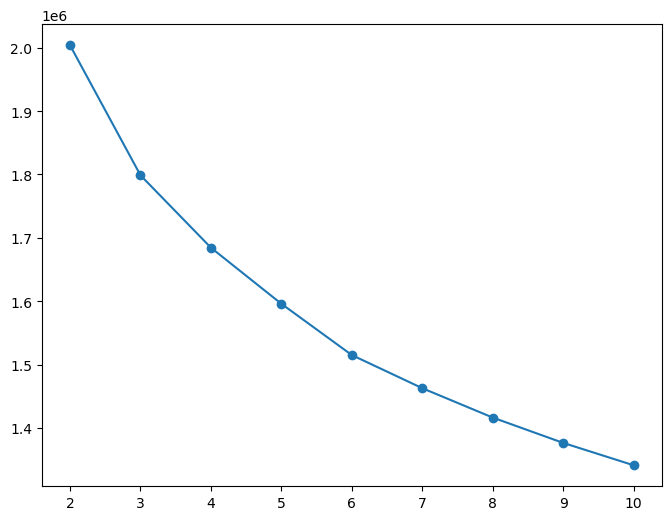

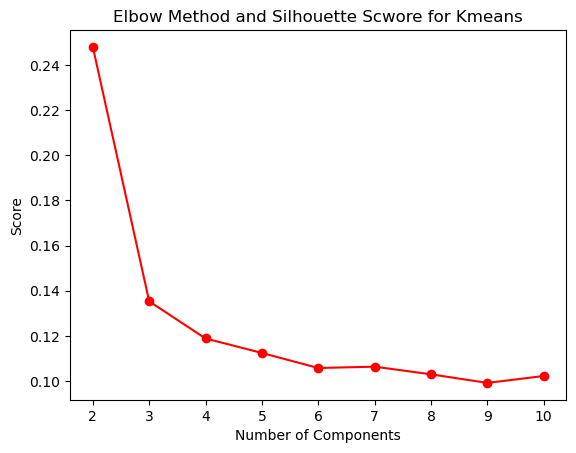

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, scores, marker='o', label="(Elbow Method")
plt.show()
plt.plot(n_components_range, silhouette_scores, marker='o', color='r', label="Silhouette Score")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.title("Elbow Method and Silhouette Scwore for Kmeans")
plt.show()

optimal clusters are 5

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

features['cluster'] = kmeans.labels_

In [19]:
user_profiles['cluster']  = kmeans.labels_

In [20]:
user_profiles

,user_id,total_orders,days_since_last_order,avg_days_between_orders,unique_products,most_frequent_aisle,most_frequent_dept,basket_size,repeat_purchase_percentage,avg_purchase_hour,weekend_shopper_percentage,last_purchased_aisle,last_purchased_dept,cluster
0,1,9,0.0,15.444444,11,23,19,18,38.888889,10.000000,0.000000,54,17,0
1,2,14,14.0,15.775862,45,24,19,58,22.413793,10.155172,0.000000,72,13,0
2,3,11,8.0,11.192308,17,24,4,26,34.615385,16.576923,0.461538,91,16,0
3,4,3,0.0,8.400000,5,74,3,5,0.000000,11.800000,0.600000,74,17,0
4,5,4,0.0,11.545455,10,120,4,11,9.090909,15.818182,0.272727,84,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,0.0,9.500000,8,21,16,10,20.000000,13.800000,0.000000,84,16,0
206205,206206,46,11.0,4.616279,51,37,1,86,40.697674,16.744186,0.313953,107,19,1
206206,206207,16,0.0,14.238806,50,84,16,67,25.373134,13.477612,0.313433,112,3,0
206207,206208,46,8.0,8.290640,108,123,4,203,46.798030,13.798030,0.177340,83,4,1


In [21]:
list(user_profiles.columns)

['user_id',
 'total_orders',
 'days_since_last_order',
 'avg_days_between_orders',
 'unique_products',
 'most_frequent_aisle',
 'most_frequent_dept',
 'basket_size',
 'repeat_purchase_percentage',
 'avg_purchase_hour',
 'weekend_shopper_percentage',
 'last_purchased_aisle',
 'last_purchased_dept',
 'cluster']

In [25]:
user_profiles['is_weekend'] = np.where(user_profiles['weekend_shopper_percentage'] > 0.5, 1, 0)

In [26]:
user_profiles.head()

,user_id,total_orders,days_since_last_order,avg_days_between_orders,unique_products,most_frequent_aisle,most_frequent_dept,basket_size,repeat_purchase_percentage,avg_purchase_hour,weekend_shopper_percentage,last_purchased_aisle,last_purchased_dept,cluster,is_weekend
0,1,9,0.0,15.444444,11,23,19,18,38.888889,10.000000,0.000000,54,17,0,0
1,2,14,14.0,15.775862,45,24,19,58,22.413793,10.155172,0.000000,72,13,0,0
2,3,11,8.0,11.192308,17,24,4,26,34.615385,16.576923,0.461538,91,16,0,0
3,4,3,0.0,8.400000,5,74,3,5,0.000000,11.800000,0.600000,74,17,0,1
4,5,4,0.0,11.545455,10,120,4,11,9.090909,15.818182,0.272727,84,16,0,0


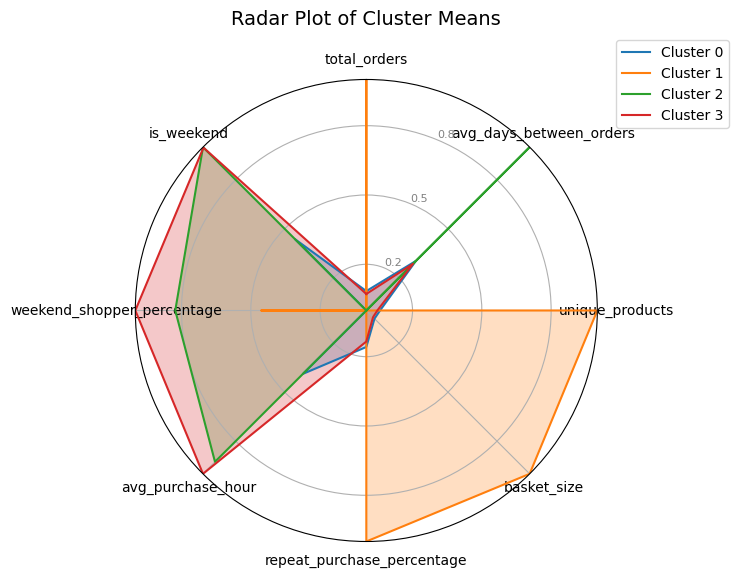

In [27]:
feature_set = [
 'total_orders',
 'avg_days_between_orders',
 'unique_products',
 'basket_size',
 'repeat_purchase_percentage',
 'avg_purchase_hour',
 'weekend_shopper_percentage',
 'is_weekend']

cluster_means = user_profiles.groupby('cluster')[feature_set].mean()

normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

labels = feature_set
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for cluster in normalized_means.index:
    values = normalized_means.loc[cluster].tolist()
    values += values[:1] 
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.2, 0.5, 0.8])
ax.set_yticklabels(['0.2', '0.5', '0.8'], color="grey", size=8)
ax.set_ylim(0, 1)


ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot of Cluster Means', size=14, y=1.1)
plt.show()

In [ ]:
user_profiles.groupby('cluster')['is_weekend'].mean()

In [29]:
# avg_days_between_orders
user_profiles.groupby('cluster')['avg_days_between_orders'].mean()

cluster
0    11.994250
1     8.786168
2    19.365223
3    11.807932
Name: avg_days_between_orders, dtype: float64

In [30]:
import dataframe_image as dfi

#### EDA on Clusters

In [31]:
user_profiles['is_weekend'] = np.where(user_profiles['weekend_shopper_percentage'] > 0.5, 1, 0)

In [32]:
user_profiles.groupby('cluster')['unique_products'].mean()

cluster
0    22.214292
1    82.918410
2    18.378393
3    21.463918
Name: unique_products, dtype: float64

In [33]:
user_profiles.groupby('cluster')['basket_size'].agg('mean')

cluster
0     30.529141
1    168.510071
2     23.248521
3     29.216476
Name: basket_size, dtype: float64

- users of cluster 1 are mostly bulk buyers and usually buy varity of items.
- buyers of cluster 0 are medium buyers they usually have moderate basket size per order and they also like to explore some varity or products.
- other clusters have buyers who like to buy less items togather and mostly they order and reorder specific items.

In [34]:
most_bought_by_cluster = user_profiles.groupby('cluster')['most_frequent_dept'].agg(lambda x: x.value_counts().idxmax())
display(pd.DataFrame(most_bought_by_cluster).merge(
    df_departments,left_on='most_frequent_dept', right_on='department_id', how='left'
).drop(columns=['department_id']))


data = []

def fn(x):
    data.append({
        "most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[0]]['aisle'].values[0] if len(x.value_counts()) > 1 else None,
        "second most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[1]]['aisle'].values[0] if len(x.value_counts()) > 1 else None, 
        "third most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[2]]['aisle'].values[0] if len(x.value_counts()) > 2 else None,
        "fourth most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[3]]['aisle'].values[0] if len(x.value_counts()) > 3 else None
    })

user_profiles.groupby('cluster')['most_frequent_aisle'].agg(fn)
pd.DataFrame(data)

,most_frequent_dept,department
0,4,produce
1,4,produce
2,4,produce
3,4,produce


,most bought aisle,second most bought aisle,third most bought aisle,fourth most bought aisle
0,fresh fruits,fresh vegetables,yogurt,packaged cheese
1,fresh fruits,fresh vegetables,yogurt,packaged vegetables fruits
2,fresh fruits,fresh vegetables,packaged cheese,water seltzer sparkling water
3,fresh fruits,fresh vegetables,packaged vegetables fruits,packaged produce


Buyers of cluster 2 are more likely to buy from dairy eggs department. Other clusters have highest sells from produce department.<br/>
- Buyers from cluster 2 prefer dairy items like yougurt, packaged cheese, milk etc.
- Buyers from other clusters usually buy fresh fruits and vegetables. They are likely to be more health concious. 

In [35]:
# avg_purchase_hour
user_profiles.groupby('cluster')['avg_days_between_orders'].mean()

cluster
0    11.994250
1     8.786168
2    19.365223
3    11.807932
Name: avg_days_between_orders, dtype: float64

- Buyers from cluster 1 are tend to be weekly buyers.
- Likewise, Buyers from cluster 4 are monthly shoppers, they have tendency to order items between 19-20 days.
- Other clusters don't have any specific buying patterns. They normally order between 10-13 days.

In [36]:
most_frequent_values = user_profiles.groupby('cluster')['weekend_shopper_percentage'].agg(lambda x: x.mode().iloc[0])
most_frequent_values

cluster
0    0.0
1    0.0
2    0.0
3    0.0
Name: weekend_shopper_percentage, dtype: float64

buyers from all clusters seems to order more likely on weekdays.

In [37]:
user_profiles.groupby('cluster')['total_orders'].agg(lambda x: x.mean())

cluster
0    10.064181
1    42.878124
2     7.058177
3     9.621026
Name: total_orders, dtype: float64

Buyers in Cluster 1 exhibit high purchasing activity across a wide range of items, demonstrating strong loyalty and consistent engagement.

In [38]:
# repeat_purchase_percentage
pd.DataFrame(user_profiles.groupby('cluster')['repeat_purchase_percentage'].mean())

,repeat_purchase_percentage
cluster,
0,21.106036
1,48.412412
2,15.984181
3,20.342600


In [39]:
# dfi.export(rppc,"mytable.png")

- Buyers in cluster 0 and 1 have 43% and 53% tendency to repeat their previous orders.
- Clusters 3,4 and 5 have repeat purchase percentages of 15-16% respectively, which are among the lowest. These clusters likely represent more transient customers who are less loyal, possibly only purchasing occasionally.

In [40]:
# avg_purchase_hour
user_profiles.groupby('cluster')['avg_purchase_hour'].agg(lambda x: x.mode().iloc[0])

cluster
0    13.0
1    13.0
2    14.0
3    13.0
Name: avg_purchase_hour, dtype: float64

#### DBScan

In [41]:
dbscan = DBSCAN(eps=0.3, min_samples=10)

user_profiles['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
user_profiles['dbscan_cluster'].value_counts()

dbscan_cluster
-1    206087
 6        20
 4        16
 1        15
 0        14
 2        13
 5        12
 8        12
 3        10
 7        10
Name: count, dtype: int64

#### GMM

In [ ]:
n_components_range = range(2, 10)
bics = []
silhouette_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(scaled_features)
    bics.append(gmm.bic(scaled_features))

    labels = gmm.predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel("Number of Components")
ax1.set_ylabel("BIC", color="tab:blue")
ax1.plot(n_components_range, bics, marker='o', label='BIC', color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Silhouette Score", color="tab:orange")
ax2.plot(n_components_range, silhouette_scores, marker='o', label='Silhouette Score', color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.tight_layout()
plt.title("BIC and Silhouette Scores for Different Number of Components")
plt.show()

In [ ]:
labels

In [ ]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(scaled_features)

user_profiles['gmm_cluster'] = gmm.predict(scaled_features)
# Assuming 'gmm' is your fitted GMM model and 'df' is your DataFrame with data points
probabilities = gmm.predict_proba(scaled_features)

# Create empty lists to store the top 3 clusters and probabilities for each point
top_2_clusters = []
top_2_probabilities = []

for prob in probabilities:
    # Get the indices of the top 3 clusters and their corresponding probabilities
    top_indices = np.argsort(prob)[::-1][:2]  # Sort probabilities in descending order and get top 3
    top_probs = prob[top_indices]
    
    # Round the probabilities to 2 decimal places
    top_probs_rounded = np.round(top_probs * 100, 2)  # Convert to percentages and round
    
    # Store the results for the current data point
    top_2_clusters.append(top_indices)
    top_2_probabilities.append(top_probs_rounded)

# Add the top 3 clusters and their probabilities to the DataFrame
user_profiles[['Top Cluster 1', 'Top Cluster 2']] = pd.DataFrame(top_2_clusters, index=user_profiles.index)
user_profiles[['Top Cluster 1 Probability (%)', 'Top Cluster 2 Probability (%)']] = pd.DataFrame(top_2_probabilities, index=user_profiles.index)

# Now your DataFrame has the top 3 clusters and their probabilities for each data poin

In [ ]:
# user_profiles.drop(columns=['Top Cluster 3'], inplace=True)

In [ ]:
user_profiles.head(15)

In [ ]:
user_profiles.groupby('cluster')['unique_products'].mean()

In [ ]:
user_profiles.groupby('cluster')['basket_size'].agg('mean')

In [ ]:
most_bought_by_cluster = user_profiles.groupby('cluster')['most_frequent_dept'].agg(lambda x: x.value_counts().idxmax())
display(pd.DataFrame(most_bought_by_cluster).merge(
    df_departments,left_on='most_frequent_dept', right_on='department_id', how='left'
).drop(columns=['department_id']))


data = []

def fn(x):
    data.append({
        "most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[0]]['aisle'].values[0] if len(x.value_counts()) > 1 else None,
        "second most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[1]]['aisle'].values[0] if len(x.value_counts()) > 1 else None, 
        "third most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[2]]['aisle'].values[0] if len(x.value_counts()) > 2 else None,
        "fourth most bought aisle" : df_aisles[df_aisles.aisle_id == x.value_counts().index[3]]['aisle'].values[0] if len(x.value_counts()) > 3 else None
    })

user_profiles.groupby('cluster')['most_frequent_aisle'].agg(fn)
pd.DataFrame(data)

In [ ]:
# avg_purchase_hour
user_profiles.groupby('cluster')['avg_purchase_hour'].agg(lambda x: x.mode().iloc[0])

In [ ]:
# repeat_purchase_percentage
pd.DataFrame(user_profiles.groupby('cluster')['repeat_purchase_percentage'].mean())

In [ ]:
most_frequent_values = user_profiles.groupby('cluster')['weekend_shopper_percentage'].agg(lambda x: x.mode().iloc[0])
most_frequent_values

In [ ]:
feature_set = [
 'total_orders',
 'avg_days_between_orders',
 'unique_products',
 'basket_size',
 'repeat_purchase_percentage',
 'avg_purchase_hour',
 'weekend_shopper_percentage',
 'is_weekend']

cluster_means = user_profiles.groupby('gmm_cluster')[feature_set].mean()
normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

labels = feature_set
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for cluster in normalized_means.index:
    values = normalized_means.loc[cluster].tolist()
    values += values[:1] 
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.2, 0.5, 0.8])
ax.set_yticklabels(['0.2', '0.5', '0.8'], color="grey", size=8)
ax.set_ylim(0, 1)


ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot of Cluster Means', size=14, y=1.1)
plt.show()

In [ ]:
user_profiles[user_profiles.cluster == 1]